# Time Series Analysis, Time Series Forecasting, and Neural Networks

| Key              | Value                                                                                                                                                                                                                                                                                                            |
|:-----------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Course Codes** | BBT 4206 and BFS 4102                                                                                                                                                                                                                                                                                            |
| **Course Names** | BBT 4206: Business Intelligence II (Week 7-9 of 13)<br>BFS 4102: Advanced Business Data Analytics (Week 7-9 of 13)                                                                                                                                                                                               |
| **Semester**     | August to November 2025                                                                                                                                                                                                                                                                                          |
| **Lecturer**     | Allan Omondi                                                                                                                                                                                                                                                                                                     |
| **Contact**      | aomondi@strathmore.edu                                                                                                                                                                                                                                                                                           |
| **Note**         | The lecture contains both theory and practice.<br/>This notebook forms part of the practice.<br/>It is intended for educational purposes only.<br/>Recommended citation: [BibTex](https://raw.githubusercontent.com/course-files/TimeSeriesForecastingandNeuralNetworks/refs/heads/main/RecommendedCitation.bib) |


## Stationarity in Time Series

### In-Built Stationarizing Mechanism in Time Series Forecasting Algorithms
1. **❌Exponential Smoothing (Simple, Double [Holt], and Triple [Holt-Winters])**
- Exponential Smoothing techniques do not require the series to be stationary.
- Instead, they explicitly model components such as trend and seasonality directly.
- They handle non-stationarity by design, rather than transforming the data to a stationary form.

2. **✅ARIMA (AutoRegressive Integrated Moving Average)**
- ARIMA explicitly includes differencing (the "I" in ARIMA) as part of the model to make the series stationary.
- You specify the `d` parameter in `ARIMA(p, d, q)`, where:
  - `d = 1` tells the model to difference the data once. This step transforms a non-stationary series into a stationary one internally.

3. **✅SARIMA (Seasonal ARIMA)**
- SARIMA extends ARIMA with seasonal differencing.
- It uses two differencing parameters:
  - `d` for non-seasonal differencing,
  - `D` for seasonal differencing over a defined period m.
- Therefore, SARIMA also has built-in mechanisms to induce both stationarity and seasonal stationarity.

4. **❌LSTM (Long Short-Term Memory Networks)**
- LSTM models do not have explicit stationarizing mechanisms.
- They learn directly from raw sequences, even if they are non-stationary.
- However, data preprocessing such as normalization and differencing often improves performance.
- LSTMs can model complex non-linear and non-stationary behavior, but they do not automatically make the data stationary.

## Step 1: Import Libraries

Confirm the following:
1. Which Python interpreter will be used to execute new code and where it is located
2. The Python version

Then install all the packages into the Jupyter notebook's virtual environment before importing them.

In [16]:
import sys
sys.executable

'/usr/bin/python3'

In [17]:
!python --version

Python 3.12.12


In [18]:
if "google.colab" in sys.modules:
    print("Installing in Google Colab")
    %pip install -r https://raw.githubusercontent.com/course-files/TimeSeriesForecastingandNeuralNetworks/refs/heads/main/requirements/colab.txt
else:
    print("Installing in dev environment")
    %pip install -r https://raw.githubusercontent.com/course-files/TimeSeriesForecastingandNeuralNetworks/refs/heads/main/requirements/dev.txt -c https://raw.githubusercontent.com/course-files/TimeSeriesForecastingandNeuralNetworks/refs/heads/main/requirements/constraints.txt

Installing in Google Colab


In [19]:
# For file and system operations
import urllib.request
import os

# For data download
import yfinance as yf

# For time series analysis
import pandas as pd
import numpy as np
import re
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

# For data visualization
import matplotlib.pyplot as plt
import mplfinance as mpf

# For time series forecasting
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

## For time series forecasting with LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# For suppressing warnings
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Ensures that matplotlib plots are displayed directly within the notebook,
# right below the code cell that produces them. It makes visualizations appear
# inline for easier viewing and analysis.
%matplotlib inline

## Step 2: Load and Preprocess/Clean the Data

### Load the Data

In [20]:
dataset_path = './data/stockprice_cleaned.csv'
url = 'https://raw.githubusercontent.com/course-files/TimeSeriesForecastingandNeuralNetworks/refs/heads/main/data/stockprice_cleaned.csv'

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    if not os.path.exists('./data'):
        os.makedirs('./data')
    urllib.request.urlretrieve(url, dataset_path)
    print("✅ Dataset downloaded")
else:
    print("✅ Dataset already exists locally")

data = pd.read_csv(dataset_path, encoding='utf-8', nrows=200000)

✅ Dataset already exists locally


### Preprocess/Clean the Data

In [21]:
# 1) Ensure datetime index and sorted

# This line converts the `Date` column in the `data` DataFrame to datetime
# objects. The `errors="coerce"` argument means that any value that cannot
# be parsed as a date will be replaced with `NaT` (Not a Time), which is
# pandas' way of marking missing or invalid dates. This helps prevent errors
# from invalid date formats and ensures the column is consistently typed.
if "Date" in data.columns:
    data["Date"] = pd.to_datetime(data["Date"], errors="coerce")
    data = data.set_index("Date")

data = data.sort_index()

# 2) Normalize column names (trim, unify, and fix common naming)
data.columns = [c.strip() for c in data.columns]
rename_map = {
    "Close/Last": "Close",
    "Adj Close": "Close",
    "Adj. Close": "Close",
    "Closing Price": "Close",
    "Open Price": "Open",
    "Opening Price": "Open",
    "High Price": "High",
    "Low Price": "Low",
    "Trade Volume": "Volume",
    "Volume (Shares)": "Volume",
    "Total Volume": "Volume",
    "High/Low": "High",
    "Low/High": "Low"
}
data = data.rename(columns=rename_map)

# 3) Define a helper to strip non-numeric characters (keep digits, dot, minus)
def to_numeric_str(s: str) -> str:
    # Handle None/NaN safely
    s = "" if s is None else str(s)
    # Strip any characters except digits, decimal point, minus
    return re.sub(r"[^0-9.\-]", "", s)

# 4) Coerce OHLC to float
ohlc_cols = [c for c in ["Open", "High", "Low", "Close"] if c in data.columns]
for c in ohlc_cols:
    data[c] = pd.to_numeric(data[c].astype(str).map(to_numeric_str), errors="coerce")

# 5) Coerce Volume to numeric (basic version: strip non-numeric)
if "Volume" in data.columns:
    data["Volume"] = pd.to_numeric(data["Volume"].astype(str).map(to_numeric_str), errors="coerce")

# Optional: if your Volume has K/M/B suffixes (e.g., 12K, 3.5M, 1.2B) and you want correct scaling:
def parse_volume(v):
    v = str(v).strip()
    if not v or v.lower() == "nan":
        return float("nan")
    mult = 1
    if v[-1] in "KkMmBb":
        suffix = v[-1].upper()
        v = to_numeric_str(v[:-1])
        mult = {"K": 1_000, "M": 1_000_000, "B": 1_000_000_000}[suffix]
    else:
        v = to_numeric_str(v)
    return float(v) * mult if v else float("nan")
if "Volume" in data.columns:
    data["Volume"] = data["Volume"].map(parse_volume)

# 6) Drop rows where any of OHLC are missing (mplfinance needs valid OHLC rows)
if ohlc_cols:
    data = data.dropna(subset=ohlc_cols)

### Confirm Cleaned Data

In [22]:
print("\n*1* The number of observations and variables")
display(data.shape)

print("\n*2* The data types:")
display(data.info())


*1* The number of observations and variables


(457, 5)


*2* The data types:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 457 entries, 2024-01-02 to 2025-10-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   457 non-null    float64
 1   High    457 non-null    float64
 2   Low     457 non-null    float64
 3   Open    457 non-null    float64
 4   Volume  457 non-null    float64
dtypes: float64(5)
memory usage: 21.4 KB


None

In [23]:
print("\n*3* The summary of the numeric columns:")
display(data.describe())

print("\n*4* The whole dataset:")
display(data)

print("\n*5* The first 5 rows in the dataset:")
display(data.head())

print("\n*6* The last 5 rows in the dataset:")
display(data.tail())


*3* The summary of the numeric columns:


,Close,High,Low,Open,Volume
count,457.000000,457.000000,457.000000,457.000000,4.570000e+02
mean,125.247974,127.350000,122.877923,125.249177,3.095923e+08
std,33.519356,33.707706,33.345147,33.612256,1.561720e+08
min,47.545158,48.159848,47.296283,47.461201,1.051570e+08
25%,104.711021,106.776566,101.473875,104.456859,1.925596e+08
50%,125.783173,128.372033,122.594359,124.964284,2.647050e+08
75%,142.612061,144.981757,140.949587,142.672050,3.970169e+08
max,192.570007,195.619995,191.059998,193.509995,1.142269e+09



*4* The whole dataset:


,Close,High,Low,Open,Volume
Date,,,,,
2024-01-02,48.143856,49.270290,47.571145,49.219317,411254000.0
2024-01-03,47.545158,48.159848,47.296283,47.461201,320896000.0
2024-01-04,47.973946,48.475693,47.484190,47.743059,306535000.0
2024-01-05,49.072388,49.522163,48.281784,48.437708,415039000.0
2024-01-08,52.226810,52.248803,49.454202,49.487187,642510000.0
...,...,...,...,...,...
2025-10-21,181.160004,182.789993,179.800003,182.789993,124240200.0
2025-10-22,180.279999,183.440002,176.759995,181.139999,162249600.0
2025-10-23,182.160004,183.029999,179.789993,180.419998,111363700.0



*5* The first 5 rows in the dataset:


,Close,High,Low,Open,Volume
Date,,,,,
2024-01-02,48.143856,49.270290,47.571145,49.219317,411254000.0
2024-01-03,47.545158,48.159848,47.296283,47.461201,320896000.0
2024-01-04,47.973946,48.475693,47.484190,47.743059,306535000.0
2024-01-05,49.072388,49.522163,48.281784,48.437708,415039000.0
2024-01-08,52.226810,52.248803,49.454202,49.487187,642510000.0



*6* The last 5 rows in the dataset:


,Close,High,Low,Open,Volume
Date,,,,,
2025-10-21,181.160004,182.789993,179.800003,182.789993,124240200.0
2025-10-22,180.279999,183.440002,176.759995,181.139999,162249600.0
2025-10-23,182.160004,183.029999,179.789993,180.419998,111363700.0
2025-10-24,186.259995,187.470001,183.500000,183.839996,131296700.0
2025-10-27,191.490005,192.000000,188.429993,189.990005,153082200.0


## Step 3: Forecast

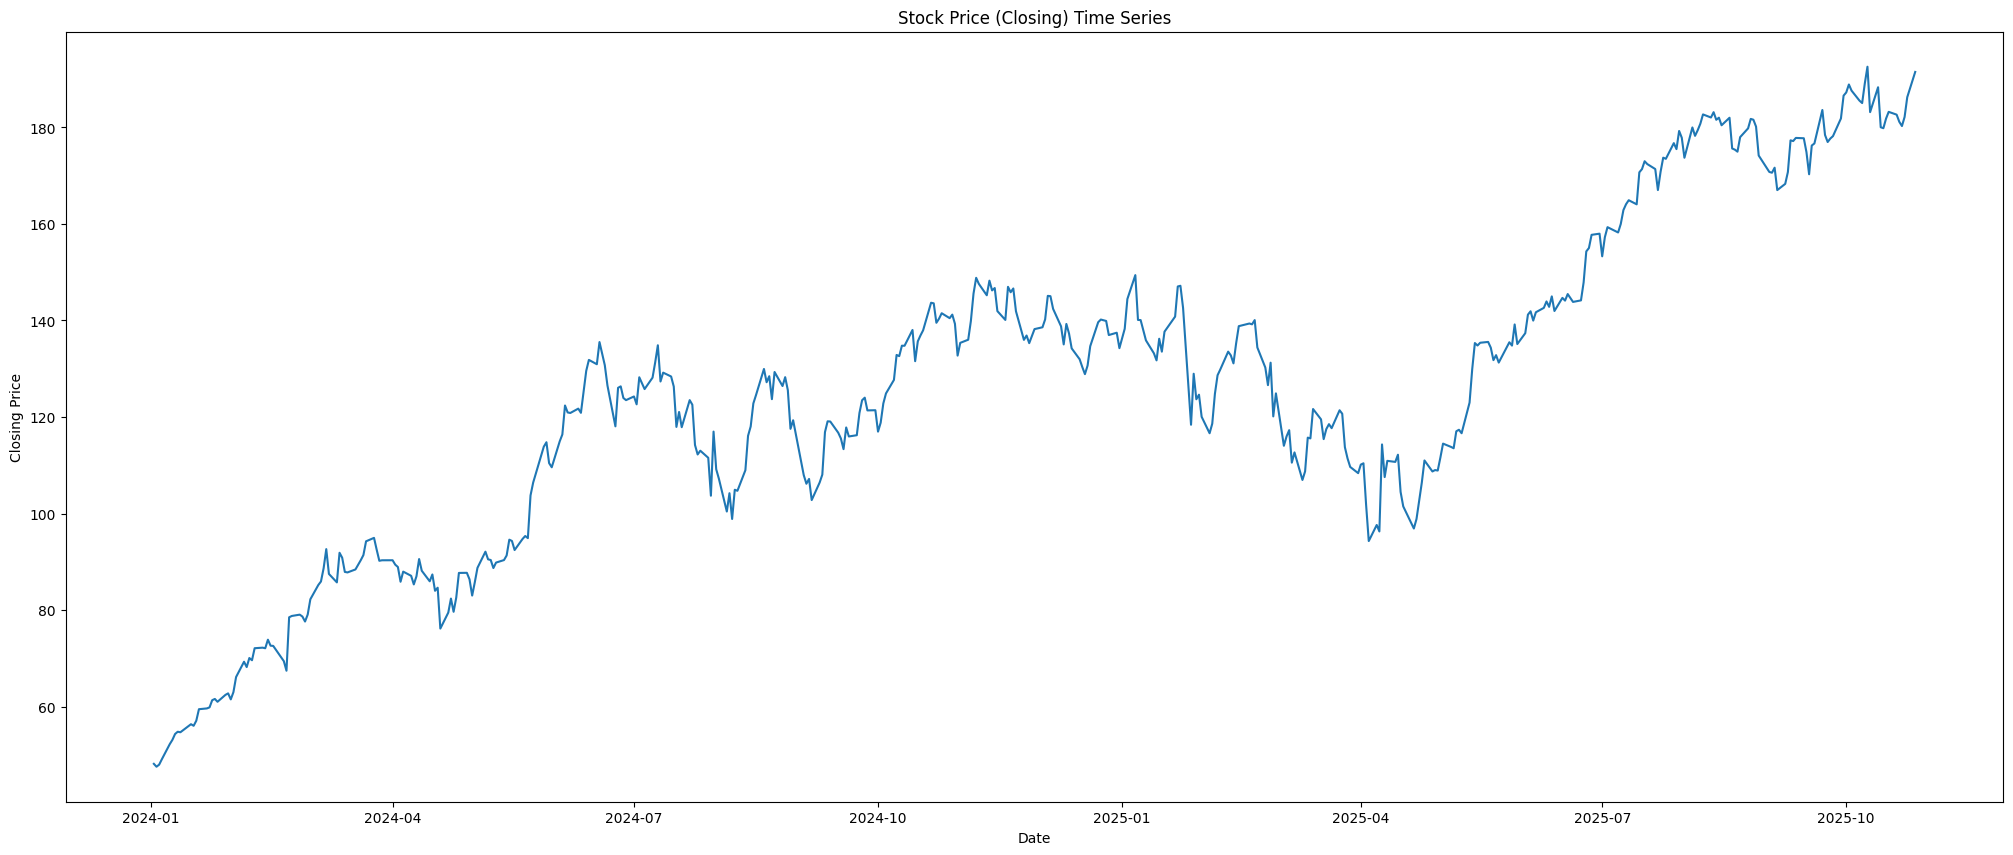

In [24]:
plt.figure(figsize=(25, 10))
plt.plot(data["Close"])
plt.title(f"Stock Price (Closing) Time Series")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

In [25]:
# If data is already a Series, it uses it directly.
# If data is a DataFrame, it selects the Close column and converts it to float64.
ts = data if isinstance(data, pd.Series) else data["Close"].astype('float64')

### Exponential Smoothing

Exponential smoothing is a time series forecasting method for univariate data. It is a weighted average of past observations, with the weights decaying exponentially as the observations get older.

**Note:** Unlike ARIMA models, some exponential smoothing models are designed to handle non-stationary data directly by explicitly modeling trend and seasonality. This is why we can apply them to the original time series.

#### Simple Exponential Smoothing (SES)

- It is normal for Simple Exponential Smoothing (SES) to produce a flat forecast (the same value for all future periods) because it does not model trend or seasonality—only the level. The forecast equals the last estimated level from the fitted model.
- For time series with trend or seasonality, it is better to use Holt’s or Holt-Winters methods instead.

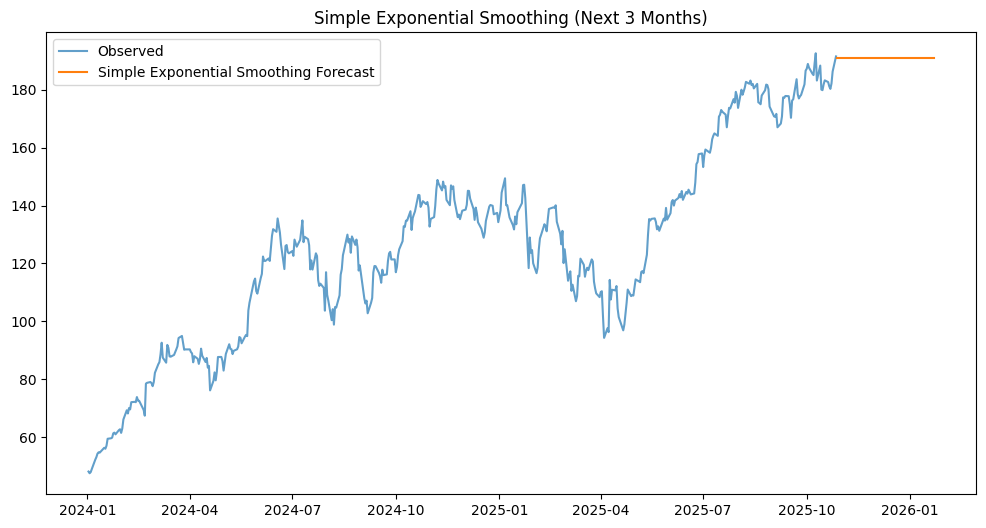

In [26]:
# Fit SES model
model_ses = SimpleExpSmoothing(ts, initialization_method="estimated").fit()

# Forecast next 63 periods
predictions_ses = model_ses.forecast(63)

# Create future index for next 63 periods (e.g., business days)
future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),
    periods=63,
    freq='B'
)

# Assign index to forecast
predictions_ses = pd.Series(predictions_ses.values, index=future_index)

# Plot observed and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed', alpha=0.7)
plt.plot(predictions_ses, label='Simple Exponential Smoothing Forecast')
plt.title('Simple Exponential Smoothing (Next 3 Months)')
plt.legend()
plt.show()

In [27]:
predictions_table = pd.DataFrame(predictions_ses)
display(predictions_table)

,0
2025-10-28,191.012172
2025-10-29,191.012172
2025-10-30,191.012172
2025-10-31,191.012172
2025-11-03,191.012172
...,...
2026-01-16,191.012172
2026-01-19,191.012172
2026-01-20,191.012172
2026-01-21,191.012172


#### Double Exponential Smoothing (Holt's Method)

Holt's method is an extension of SES that can handle time series data with a trend.

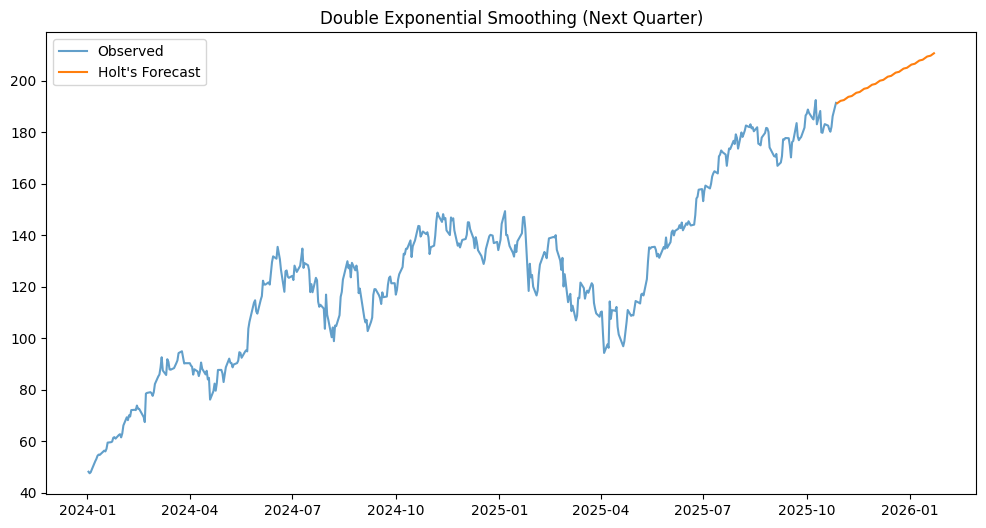

In [28]:
model_holt = Holt(ts, initialization_method="estimated").fit()
predictions_holt = model_holt.forecast(63)

future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),  # Use business days if daily data
    periods=63,
    freq='B'
)
predictions_holt = pd.Series(predictions_holt.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed', alpha=0.7)
plt.plot(predictions_holt, label="Holt's Forecast")
plt.title("Double Exponential Smoothing (Next Quarter)")
plt.legend()
plt.show()

In [29]:
predictions_table = pd.DataFrame(predictions_holt)
display(predictions_table)

,0
2025-10-28,191.313943
2025-10-29,191.627408
2025-10-30,191.940873
2025-10-31,192.254337
2025-11-03,192.567802
...,...
2026-01-16,209.494891
2026-01-19,209.808355
2026-01-20,210.121820
2026-01-21,210.435285


#### Triple Exponential Smoothing (Holt-Winters Method)

The Holt-Winters method extends Holt's method to capture seasonality.

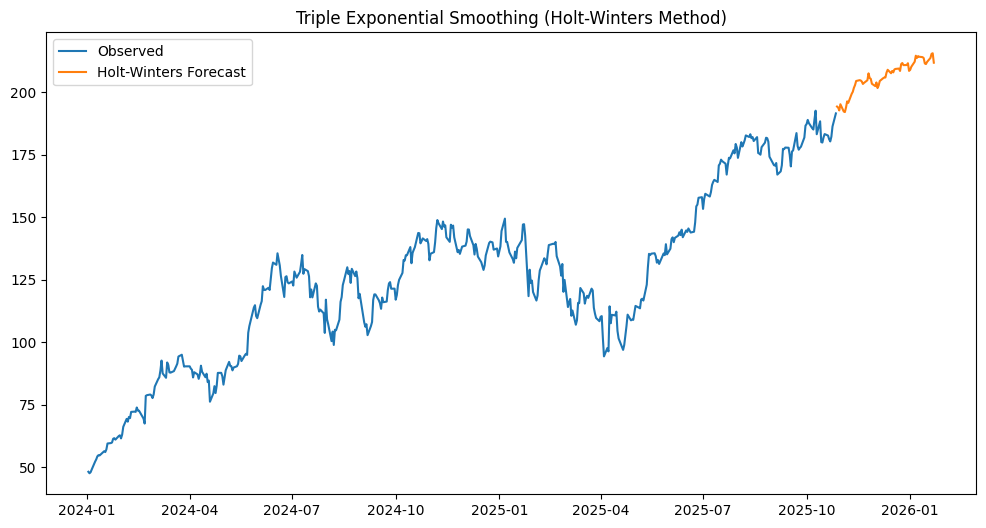

In [30]:
model_hw = ExponentialSmoothing(ts, seasonal_periods=63, trend='add', seasonal='add', initialization_method="estimated").fit()
predictions_hw = model_hw.forecast(63)

future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),
    periods=63,  # 63 business days ≈ 3 months
    freq='B'
)
predictions_hw = pd.Series(predictions_hw.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(predictions_hw, label='Holt-Winters Forecast')
plt.title('Triple Exponential Smoothing (Holt-Winters Method)')
plt.legend()
plt.show()

In [31]:
predictions_table = pd.DataFrame(predictions_hw)
display(predictions_table)

,0
2025-10-28,194.231965
2025-10-29,193.832277
2025-10-30,192.678038
2025-10-31,195.158643
2025-11-03,192.235962
...,...
2026-01-16,212.086997
2026-01-19,213.664931
2026-01-20,215.333810
2026-01-21,215.537580


### ARIMA

ARIMA stands for AutoRegressive Integrated Moving Average. It is a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors.

An ARIMA model is characterized by 3 parameters: (p, d, q).

* **p:** The number of lag observations included in the model (lag order).
* **d:** The number of times that the raw observations are differenced (degree of differencing).
* **q:** The size of the moving average window (order of moving average).

**Important Note:** You might wonder why we are using the original `data` which is non-stationary. The `statsmodels` implementation of ARIMA is smart. The `d` parameter in the `order=(p,d,q)` argument tells the model how many times to difference the data. So, the model takes care of the differencing internally. This is the standard and recommended way to use ARIMA models in `statsmodels`, as it simplifies the process and automatically returns the forecasts on the original scale.

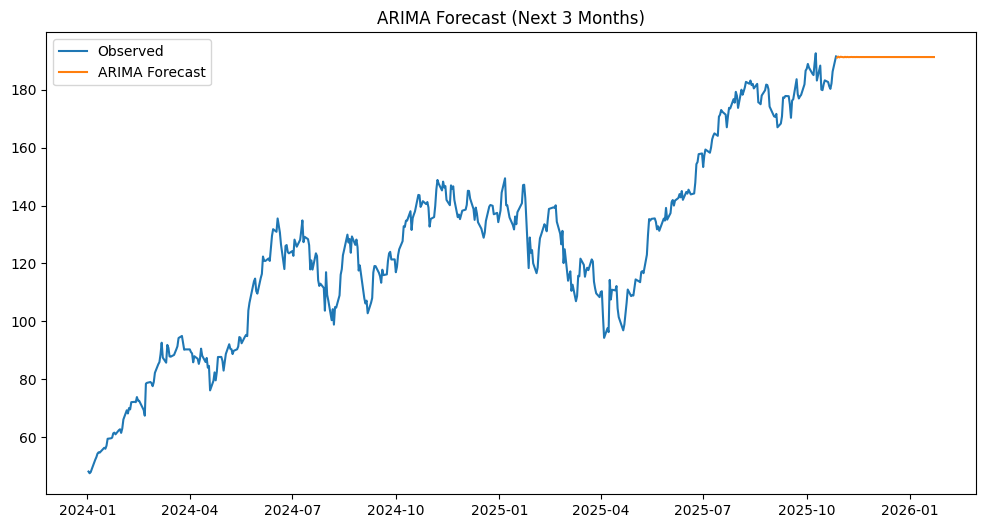

In [32]:
# Fit ARIMA model on the closing price series
model_arima = ARIMA(ts, order=(1, 1, 1)).fit()
predictions_arima = model_arima.forecast(steps=63)

# Create a future index for the next 63 business days
future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),
    periods=63,
    freq='B'
)
predictions_arima = pd.Series(predictions_arima.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(predictions_arima, label='ARIMA Forecast')
plt.title('ARIMA Forecast (Next 3 Months)')
plt.legend()
plt.show()

In [33]:
predictions_table = pd.DataFrame(predictions_arima)
display(predictions_table)

,0
2025-10-28,191.094950
2025-10-29,191.413601
2025-10-30,191.156578
2025-10-31,191.363892
2025-11-03,191.196673
...,...
2026-01-16,191.271331
2026-01-19,191.271332
2026-01-20,191.271331
2026-01-21,191.271332


### SARIMA

SARIMA (Seasonal ARIMA) is an extension of ARIMA that supports time series data with a seasonal component.

A SARIMA model is characterized by 7 parameters: (p, d, q) x (P, D, Q, s).

* **(p, d, q):** The non-seasonal parameters of the ARIMA model.
* **(P, D, Q, s):** The seasonal parameters of the model, where 's' is the number of time steps for a single seasonal period.

Just like with ARIMA, we use the original time series here and let the model handle the differencing (both seasonal and non-seasonal) for us via the `d` and `D` parameters.

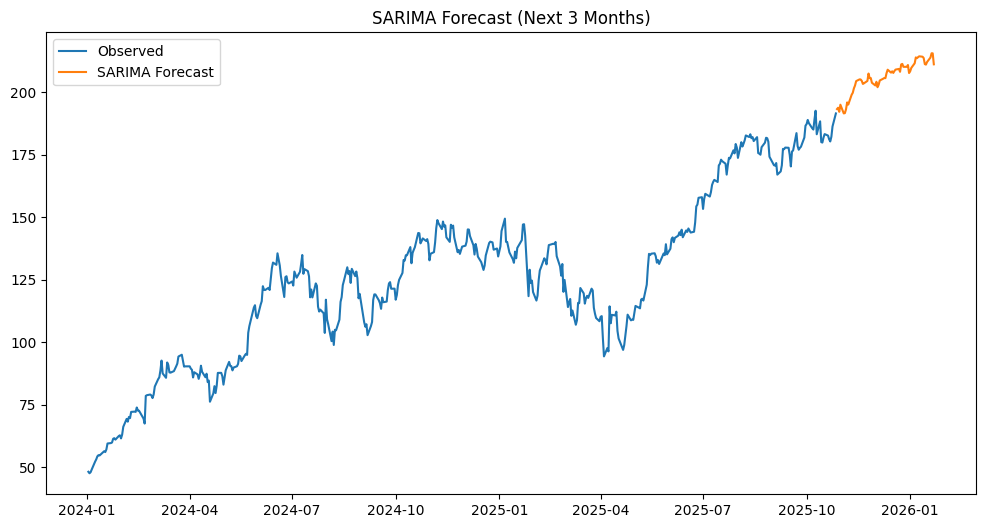

In [34]:
# Change from s = 12 to s = 63 for quarterly data
model_sarima = SARIMAX(ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 63)).fit()
predictions_sarima = model_sarima.forecast(steps=63)

future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),
    periods=63,
    freq='B'
)
predictions_sarima = pd.Series(predictions_sarima.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(predictions_sarima, label='SARIMA Forecast')
plt.title('SARIMA Forecast (Next 3 Months)')
plt.legend()
plt.show()


In [35]:
predictions_table = pd.DataFrame(predictions_sarima)
display(predictions_table)

,0
2025-10-28,193.230924
2025-10-29,193.769909
2025-10-30,192.124441
2025-10-31,194.977598
2025-11-03,191.498646
...,...
2026-01-16,212.071812
2026-01-19,213.832079
2026-01-20,215.551461
2026-01-21,215.528429


### Prophet

- Resetting the index is necessary when preparing data for Prophet because Prophet expects a DataFrame with two columns:
    - ds (date/time column)
    - y (value column)
- If your time series uses the date as the index, resetting the index moves the date from the index into a column, making it accessible for Prophet.
- This ensures the DataFrame has the required structure for Prophet to fit and forecast.

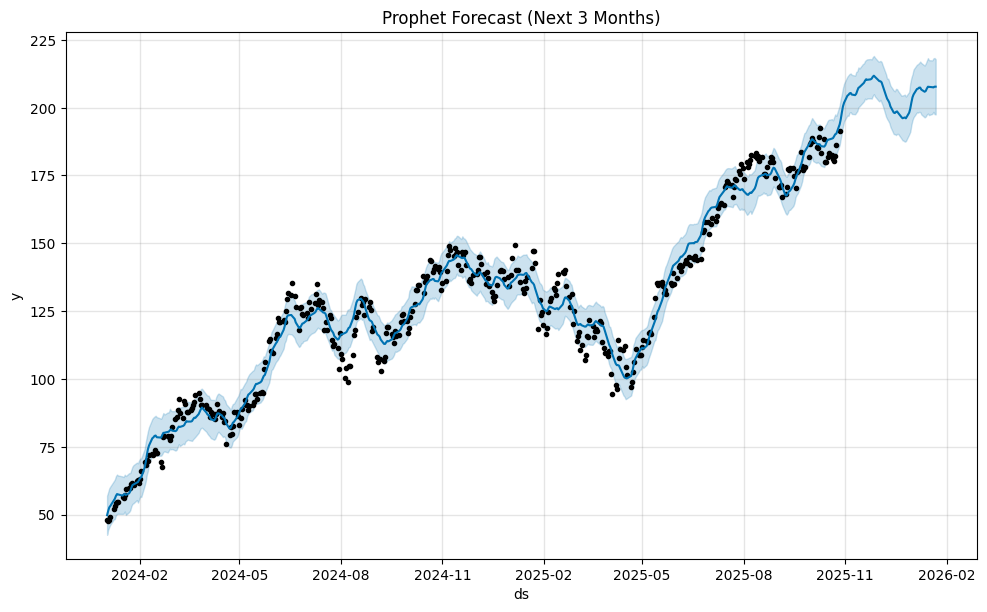

In [36]:
# Prepare data for Prophet
df_prophet = ts.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_prophet.columns = ['ds', 'y']  # Ensure correct column names

# Define holidays
# holidays = pd.DataFrame({
#     'holiday': ['new_year', 'christmas'],
#     'ds': pd.to_datetime(['2024-01-01', '2024-12-25'])
# })

# Create holiday dates for each year
years = range(2020, 2026)  # Adjust the range as needed
holidays = pd.DataFrame({
    'holiday': ['new_year'] * len(years) + ['christmas'] * len(years),
    'ds': pd.to_datetime(
        [f'{year}-01-01' for year in years] + [f'{year}-12-25' for year in years]
    )
})

# Initialize Prophet with custom settings
tf_prophet_model = Prophet(
    holidays=holidays,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
tf_prophet_model.add_seasonality(name='quarterly', period=63, fourier_order=5)

# Fit Prophet model
tf_prophet_model.fit(df_prophet)

# Create future DataFrame for the next 63 business days
future = tf_prophet_model.make_future_dataframe(periods=63, freq='B')

# Forecast
forecast = tf_prophet_model.predict(future)

# Plot forecast
fig = tf_prophet_model.plot(forecast)
plt.title('Prophet Forecast (Next 3 Months)')
plt.show()

- The DataFrame returned by Prophet's predict method contains the following columns:
    - ds: The datestamp for each prediction.
    - yhat: The predicted value (forecast) for each date.
    - yhat_lower: The lower bound of the uncertainty interval for the forecast.
    - yhat_upper: The upper bound of the uncertainty interval for the forecast.
    - trend: The estimated trend component.
    - trend_lower / trend_upper: Lower/upper bounds for the trend.
    - additive_terms: Sum of all additive components (seasonality, holidays, etc.).
    - additive_terms_lower / additive_terms_upper: Bounds for additive terms.
    - weekly, yearly, daily, holidays: Seasonality and holiday components (if modeled).
    - weekly_lower / weekly_upper, etc.: Bounds for each seasonal/holiday component.

- Not all columns appear if certain components (like holidays or specific seasonalities) are not included in the model. The most important column for predictions is yhat.

In [37]:
predictions_table = pd.DataFrame(forecast)
display(predictions_table)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,christmas,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-01-02,41.783393,42.543439,56.956937,41.783393,41.783393,7.986433,7.986433,7.986433,0.0,...,-1.561036,-1.561036,-1.561036,6.849710,6.849710,6.849710,0.0,0.0,0.0,49.769827
1,2024-01-03,42.618255,44.398599,58.269747,42.618255,42.618255,8.713053,8.713053,8.713053,0.0,...,-1.025528,-1.025528,-1.025528,7.037261,7.037261,7.037261,0.0,0.0,0.0,51.331308
2,2024-01-04,43.453117,45.397039,59.698722,43.453117,43.453117,9.190109,9.190109,9.190109,0.0,...,-0.719130,-0.719130,-0.719130,7.249616,7.249616,7.249616,0.0,0.0,0.0,52.643227
3,2024-01-05,44.287979,46.306246,60.358370,44.287979,44.287979,8.904465,8.904465,8.904465,0.0,...,-1.127359,-1.127359,-1.127359,7.476294,7.476294,7.476294,0.0,0.0,0.0,53.192444
4,2024-01-08,46.792565,48.149170,62.232071,46.792565,46.792565,8.324557,8.324557,8.324557,0.0,...,-1.617676,-1.617676,-1.617676,8.136064,8.136064,8.136064,0.0,0.0,0.0,55.117123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,2026-01-16,198.693028,197.265988,217.501781,192.028160,205.478726,8.978468,8.978468,8.978468,0.0,...,-1.127359,-1.127359,-1.127359,8.121831,8.121831,8.121831,0.0,0.0,0.0,207.671496
516,2026-01-19,199.322524,197.725461,217.449512,192.433887,206.233364,8.230661,8.230661,8.230661,0.0,...,-1.617676,-1.617676,-1.617676,7.153009,7.153009,7.153009,0.0,0.0,0.0,207.553186
517,2026-01-20,199.532357,198.468597,218.196674,192.551268,206.563837,7.928085,7.928085,7.928085,0.0,...,-1.561036,-1.561036,-1.561036,6.736884,6.736884,6.736884,0.0,0.0,0.0,207.460442
518,2026-01-21,199.742189,197.603514,218.319899,192.647704,206.924563,8.003881,8.003881,8.003881,0.0,...,-1.025528,-1.025528,-1.025528,6.285379,6.285379,6.285379,0.0,0.0,0.0,207.746070


### LSTM baseline
LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) designed to learn from sequential data, making it well-suited for time series forecasting.
TensorFlow (with Keras) is a widely used framework for building LSTM and other neural networks. It is a good starting point for time series forecasting with LSTM.
Below is a simple baseline example for LSTM time series forecasting using TensorFlow/Keras:
Explanation:
The code scales the data, creates input sequences, splits into train/test, builds a simple LSTM model, trains it, and forecasts future values.

- `window_size = 63` defines the number of past time steps used to predict the next value. Ideally, the window size should be determined by the length of the seasonality in the time series. The length of the seasonality can be determined by testing several values and choosing the one that gives the best forecast.
- The function `create_sequences(data, window_size)` takes the time series data (after it has been scaled) and breaks it into overlapping sequences.
    - Suppose your scaled data looks like this:
        - [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
        - With a `window_size` of 3, the function will create sequences like:
            - `X: [[1, 2, 3], [2, 3, 4], [3, 4, 5], ..., [10, 11, 12]]`
            - `y: [4, 5, 6, ..., 13]`
    - That means each row in X is one training sample, consisting of three past values, and each corresponding value in y is the next one that follows.

- Without scaling, the model might learn wrong weight magnitudes or fail to converge properly.
- `X = X.reshape((X.shape[0], window_size, 1))`: An LSTM model expects 3D input, not 2D. The three dimensions are:
    - Samples (number of sequences)
    - Timesteps per sequence
    - Features per timestep (how many values are recorded at each time step)

- LSTM processes sequences one time step at a time internally. To do that, it needs to know:
    - How many time steps are in each sequence (`window_size`).
    - How many features to read at each step (here, 1, the closing price).

- `model = Sequential([...])`

- A Sequential model in Keras means layers are stacked one after another, each feeding directly into the next.
- There are two layers in this case:
`LSTM(50, activation='tanh', input_shape=(window_size, 1))`
    - This is the core recurrent layer.
    - It has 50 memory units (neurons).
    - It expects input sequences of length `window_size`, each with 1 feature.
    - The activation function 'tanh' is standard for LSTMs — it controls how information flows and is remembered over time.
    - `Dense(1)`: This is the output layer. It takes the last LSTM output and produces a single number — your prediction of the next time-step value.

- `model.compile(optimizer='adam', loss='mse')`: This line configures how the model learns.
    - Optimizer: 'adam' (Adaptive Moment Estimation) is an efficient gradient-based optimizer that adjusts learning rates automatically.
    - Loss: 'mse' (Mean Squared Error) measures how far predictions deviate from actual values. It is standard for regression tasks like forecasting.
    - Therefore, the model will minimize the average squared difference between predicted and true values.

- `model.fit(...)`: This line trains the model.
    - X, y: your training data (inputs and true outputs).
    - epochs=30: the model will pass through the entire dataset 30 times. Increasing epochs can improve learning but may cause overfitting if the model memorizes the training data.
    - batch_size=16: the model updates weights after processing every 16 samples.
    - validation_split=0.1: 10% of the data is held out for validation (to monitor overfitting).
    - verbose=0: hides the progress output for a cleaner notebook.

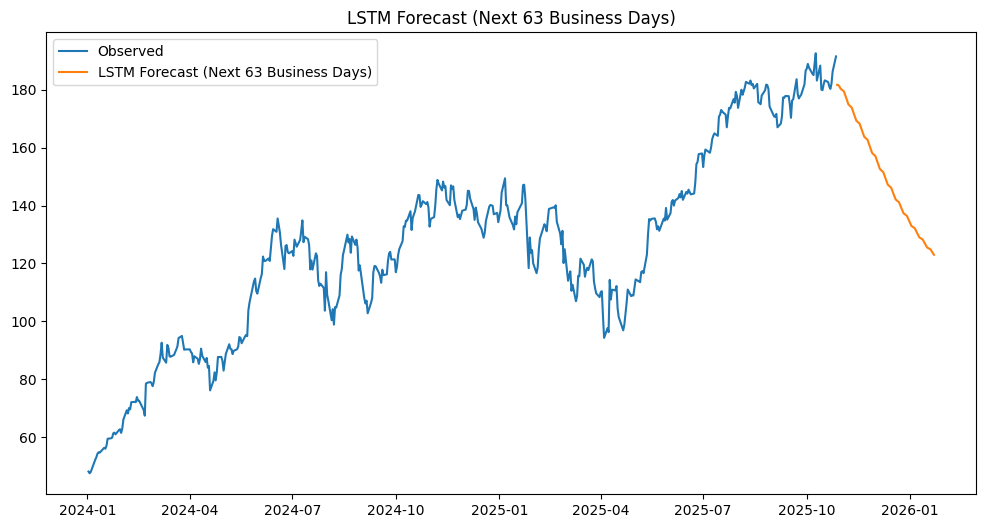

In [38]:
# --- Baseline LSTM using ts ---
# TODO: Change from `window_size = 12` to `window_size = 63` for quarterly data
window_size = 63

# Scale the data
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_ts, window_size)
X = X.reshape((X.shape[0], window_size, 1))

# Build and train LSTM model
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=30, batch_size=16, validation_split=0.1, verbose=0)

# Forecast next 63 business days
last_sequence = scaled_ts[-window_size:].reshape(1, window_size, 1)
future_preds_scaled = []
for _ in range(63):
    pred = model.predict(last_sequence, verbose=0)
    future_preds_scaled.append(pred[0, 0])
    last_sequence = np.concatenate([last_sequence[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)

future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()
future_index = pd.date_range(start=ts.index[-1] + pd.offsets.BDay(1), periods=63, freq='B')

# --- Plot the forecast ---
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(future_index, future_preds, label='LSTM Forecast (Next 63 Business Days)')
plt.title('LSTM Forecast (Next 63 Business Days)')
plt.legend()
plt.show()

In [39]:
# --- Display forecasted data in a table ---
forecast_table = pd.DataFrame({'LSTM Forecast': future_preds}, index=future_index)
display(forecast_table)

,LSTM Forecast
2025-10-28,181.662994
2025-10-29,181.607132
2025-10-30,181.138962
2025-10-31,180.372375
2025-11-03,179.417343
...,...
2026-01-16,125.500046
2026-01-19,124.848465
2026-01-20,124.213699
2026-01-21,123.595612


### LSTM with hyperparameter tuning

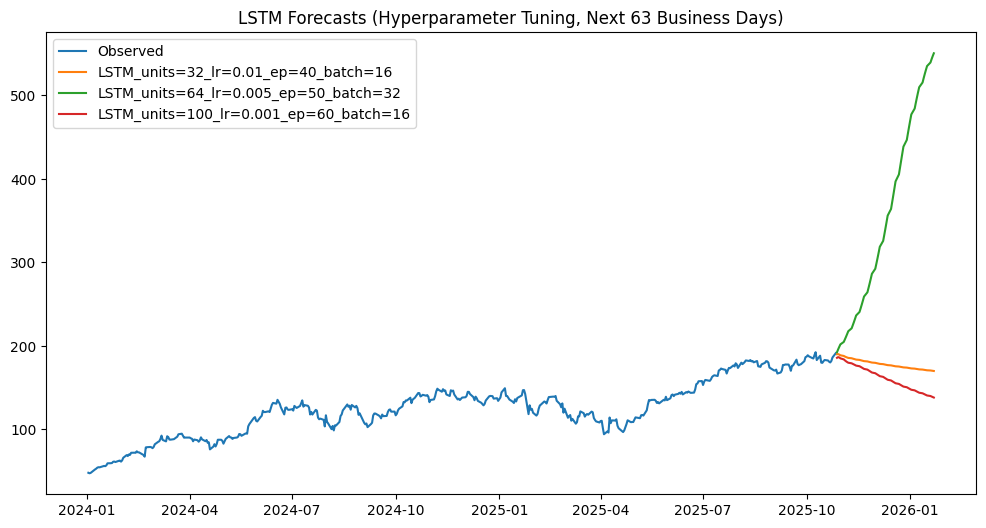

In [40]:
# --- Data Preparation ---
window_size = 63
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_ts, window_size)
X = X.reshape((X.shape[0], window_size, 1))

# --- Hyperparameter Grid ---
hyperparams = [
    {'units': 32, 'lr': 0.01, 'epochs': 40, 'batch': 16},
    {'units': 64, 'lr': 0.005, 'epochs': 50, 'batch': 32},
    {'units': 100, 'lr': 0.001, 'epochs': 60, 'batch': 16}
]

results = {}
for params in hyperparams:
    model = Sequential([
        LSTM(params['units'], activation='tanh', input_shape=(window_size, 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=params['lr']), loss='mse')
    model.fit(X, y, epochs=params['epochs'], batch_size=params['batch'], validation_split=0.1, verbose=0)
    # Forecast next 63 business days
    last_seq = scaled_ts[-window_size:].reshape(1, window_size, 1)
    preds_scaled = []
    for _ in range(63):
        pred = model.predict(last_seq, verbose=0)
        preds_scaled.append(pred[0, 0])
        last_seq = np.concatenate([last_seq[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)
    preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
    key = f"LSTM_units={params['units']}_lr={params['lr']}_ep={params['epochs']}_batch={params['batch']}"
    results[key] = preds

future_index = pd.date_range(start=ts.index[-1] + pd.offsets.BDay(1), periods=63, freq='B')
results_df = pd.DataFrame(results, index=future_index)

# --- Display Results ---
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
for col in results_df.columns:
    plt.plot(results_df.index, results_df[col], label=col)
plt.title('LSTM Forecasts (Hyperparameter Tuning, Next 63 Business Days)')
plt.legend()
plt.show()

In [41]:
display(results_df)

,LSTM_units=32_lr=0.01_ep=40_batch=16,LSTM_units=64_lr=0.005_ep=50_batch=32,LSTM_units=100_lr=0.001_ep=60_batch=16
2025-10-28,190.145172,192.616821,185.847992
2025-10-29,190.270050,195.924515,186.641464
2025-10-30,189.676422,198.971405,186.206192
2025-10-31,188.862549,201.908676,185.177124
2025-11-03,188.064728,204.858337,183.951736
...,...,...,...
2026-01-16,170.886566,535.260010,140.712738
2026-01-19,170.677582,539.477234,140.081116
2026-01-20,170.471146,543.426514,139.459671
2026-01-21,170.267227,547.117737,138.848358


In [42]:
import numpy as np

# Get the last 63 actual values as ground truth
actual = ts[-63:].values

# Calculate RMSE for each forecast column
rmse_results = {}
for col in results_df.columns:
    preds = results_df[col].values
    rmse = np.sqrt(np.mean((preds - actual) ** 2))
    rmse_results[col] = rmse

# Display RMSE results
for key, value in rmse_results.items():
    print(f"{key}: RMSE = {value:.4f}")

LSTM_units=32_lr=0.01_ep=40_batch=16: RMSE = 9.3222
LSTM_units=64_lr=0.005_ep=50_batch=32: RMSE = 210.6074
LSTM_units=100_lr=0.001_ep=60_batch=16: RMSE = 25.2964


### LSTM with hyperparameter tuning using your GPU with TensorFlow

To ensure you have compatible NVIDIA drivers and CUDA/cuDNN installed for TensorFlow GPU support:
1. Check your GPU model:
Run nvidia-smi in the terminal to see your GPU and driver version.
2. Install the latest NVIDIA driver:
Download and install the latest driver for your GPU from the NVIDIA Driver Downloads page.
3. Check TensorFlow compatibility:
Refer to the TensorFlow GPU support guide for the required CUDA and cuDNN versions for your TensorFlow release.
4. Install CUDA Toolkit:
Download the correct CUDA version from the NVIDIA CUDA Toolkit.
5. Install cuDNN:
Download the matching cuDNN version from the NVIDIA cuDNN Archive.
6. Add CUDA and cuDNN to your PATH:
Add the bin and lib folders of CUDA and cuDNN to your system environment variables.
7. Verify installation:
Run the following in Python to check if TensorFlow detects your GPU:

In [43]:
print("Number of usable GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Number of usable GPUs Available: 1


Num GPUs Available: 1


,LSTM_units=32_lr=0.01_ep=40_batch=16,LSTM_units=64_lr=0.005_ep=50_batch=32,LSTM_units=100_lr=0.001_ep=60_batch=16
2025-10-28,189.672791,189.657440,183.398651
2025-10-29,188.647949,190.975021,183.378143
2025-10-30,186.707062,191.417068,182.265488
2025-10-31,184.714142,191.604874,180.682266
2025-11-03,182.882843,191.796310,178.894241
...,...,...,...
2026-01-16,128.246811,226.573853,109.439758
2026-01-19,127.538361,227.416626,108.708458
2026-01-20,126.839676,228.268143,107.995979
2026-01-21,126.150673,229.128555,107.302017


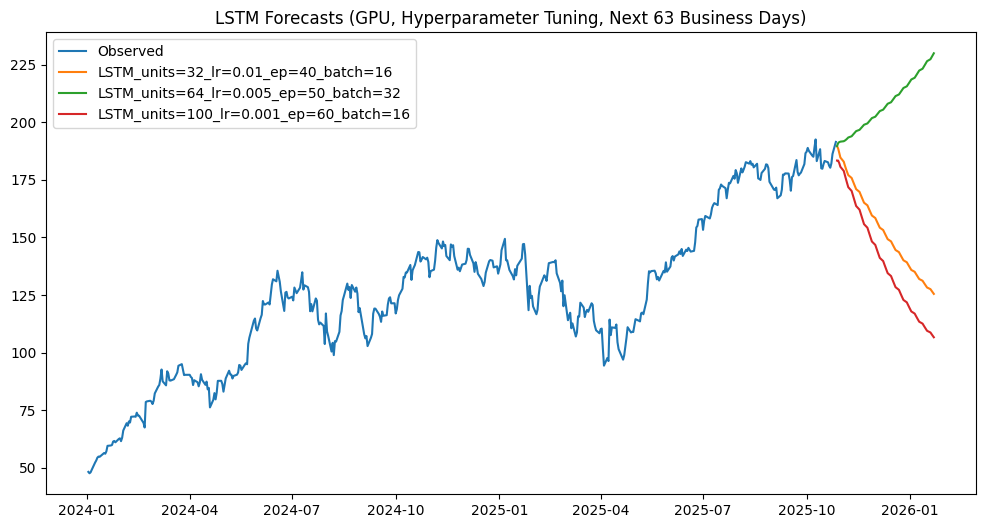

In [44]:
# Check GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
assert len(tf.config.list_physical_devices('GPU')) > 0, "No usable GPUs found."

window_size = 12
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_ts, window_size)
X = X.reshape((X.shape[0], window_size, 1))

hyperparams = [
    {'units': 32, 'lr': 0.01, 'epochs': 40, 'batch': 16},
    {'units': 64, 'lr': 0.005, 'epochs': 50, 'batch': 32},
    {'units': 100, 'lr': 0.001, 'epochs': 60, 'batch': 16}
]

results = {}
with tf.device('/GPU:0'):
    for params in hyperparams:
        model = Sequential([
            LSTM(params['units'], activation='tanh', input_shape=(window_size, 1)),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=params['lr']), loss='mse')
        model.fit(X, y, epochs=params['epochs'], batch_size=params['batch'], validation_split=0.1, verbose=0)
        # Forecast next 63 business days
        last_seq = scaled_ts[-window_size:].reshape(1, window_size, 1)
        preds_scaled = []
        for _ in range(63):
            pred = model.predict(last_seq, verbose=0)
            preds_scaled.append(pred[0, 0])
            last_seq = np.concatenate([last_seq[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)
        preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
        key = f"LSTM_units={params['units']}_lr={params['lr']}_ep={params['epochs']}_batch={params['batch']}"
        results[key] = preds

future_index = pd.date_range(start=ts.index[-1] + pd.offsets.BDay(1), periods=63, freq='B')
results_df = pd.DataFrame(results, index=future_index)
display(results_df)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
for col in results_df.columns:
    plt.plot(results_df.index, results_df[col], label=col)
plt.title('LSTM Forecasts (GPU, Hyperparameter Tuning, Next 63 Business Days)')
plt.legend()
plt.show()